<a href="https://colab.research.google.com/github/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/image2xml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# input.jpg $\rightarrow$ output.xml
### Cuaderon para transformar las predicciones al formato musicxml

## Librerías

In [ ]:
%%capture
pip install py_midicsv

In [ ]:
%%capture
pip install MIDIUtil

In [ ]:
%%capture
pip install pretty_midi

In [ ]:
%%capture
!pip install icevision[all]==0.5.1

In [ ]:
%%capture
!pip install torchtext==0.8.1

In [ ]:
%%capture
!pip install fastai --upgrade

In [ ]:
%%capture
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-spa
!pip install pytesseract
!pip install tesseract

In [ ]:
from icevision.all import *
from fastai.vision.all import *
import cv2
import pickle
import midiutil
import pretty_midi
from pytesseract import Output
import pytesseract
import IPython.display as ipd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
import statistics
import py_midicsv as pm
import random
import operator
import pickle
import sys
import os
import json
import music21 as m21

## Dataset y funciones

In [ ]:
%%capture
!wget https://www.dropbox.com/s/u2ekoltvu35kfjw/Fotos.zip?dl=1 -O Fotos.zip
!unzip Fotos.zip

In [ ]:
with open("Obras_final.pickle", "rb") as f:
    Obras_final = pickle.load(f)
with open("ini_Obras.pickle", "rb") as f:
    ini_Obras = pickle.load(f)

In [ ]:
def mostrarImagen(img):
  fig, ax = plt.subplots(1,1,figsize=(16,16))
  ax.imshow(img,cmap=plt.cm.binary)
  ax.axis('off')
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])
  plt.show()

In [1]:
import xml.etree.ElementTree as ET
from xml.dom import minidom


def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

- **Para devolver una lista con los símbolos musicales**

In [ ]:
def get_iou(bb1, bb2):
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
def remove_notas(bboxs,labels,scores):
  n = len(bboxs)
  L = []
  for i in range(0,n):
    k = len(bboxs[i:])
    bb1 = bboxs[i]
    l1 = labels[i]
    s1 = scores[i]
    for j in range(0,k):
      bb2 = bboxs[i:][j]
      l2 = labels[i:][j]
      s2 = scores[i:][j]
      if bb1[2]-bb1[0] >= 55 and 'nota' in l1:
        L.append(i)
      elif get_iou(bb1, bb2) > 0.5 and 'nota' in l1 and 'nota' in l2:
        if l1 > l2:
          L.append(i+j)
        if l1 < l2:
          L.append(i)
        if l1 == l2 and get_iou(bb1, bb2) < 1:
          if s1 > s2:
            L.append(i+j)
          else:
            L.append(i)
  L = list(np.unique(L))
  b,l,s = [],[],[]
  for i in range(0,n):
    if not(i in L):
      b.append(bboxs[i])
      l.append(labels[i])
      s.append(scores[i])
  return b,l,s

In [ ]:
d={'background':0,'claved':1, 'claves':2, 'clavef':3, 'nota1':4, 'nota2':5, 'nota4':6, 'nota1:2':7, 'nota1:4':8, 'notae':9, 'sos':10, 'bem':11, 'bec':12, 'sil0':13, 'sil1':14, 'sil2':15, 'sil1:2':16, 'sil1:4':17, '2x4':18, '3x4':19, '4x4':20, '6x8':21, 'punt':22, 'liga':23,'3':24,'line':25,'P2':26, 'nota1:8':27, 'cal':28, '3x2':29,'mf':30,'P1':31,'check':32,'3x8':33,'2x2':34}
d = {v: k for k, v in d.items()}

def qsort(bboxs,labels,scores):
  if bboxs == []:
    return bboxs,labels,scores
  bbox = bboxs[0]
  label = labels[0]
  score = scores[0]
  n = len(labels[1:])
  bboxsL,labelsL,scoresL = qsort([b for b in bboxs[1:] if b[0] < bbox[0]],[labels[1:][i] for i in range(0,n) if bboxs[1:][i][0] < bbox[0]],[scores[1:][i] for i in range(0,n) if bboxs[1:][i][0] < bbox[0]])
  bboxsU,labelsU,scoresU = qsort([b for b in bboxs[1:] if b[0] >= bbox[0]],[labels[1:][i] for i in range(0,n) if bboxs[1:][i][0] >= bbox[0]],[scores[1:][i] for i in range(0,n) if bboxs[1:][i][0] >= bbox[0]])

  return bboxsL + [bbox] + bboxsU, labelsL + [label] + labelsU, scoresL + [score] + scoresU

def pentimage2pred(test):
  if type(test) == str:
    test = cv2.imread(test)
  Y,X,_=test.shape
  infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=923), tfms.A.Normalize()])
  infer_ds = Dataset.from_images([test], infer_tfms)
  infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
  samples, preds = faster_rcnn.predict_dl(model=detector, infer_dl=infer_dl)
  L = []
  labels = list(preds[0]['labels'])
  bboxs = preds[0]['bboxes']
  for i in range(0,len(labels)):
    xmin=bboxs[i].xmin
    ymin=bboxs[i].ymin-(samples[0]['img'].shape[0]-samples[0]['height'])/2
    xmax=bboxs[i].xmax
    ymax=bboxs[i].ymax-(samples[0]['img'].shape[0]-samples[0]['height'])/2
    xmin=int(X*xmin/samples[0]['width'])
    ymin=int(Y*ymin/samples[0]['height'])
    xmax=int(X*xmax/samples[0]['width'])
    ymax=int(Y*ymax/samples[0]['height'])
    L.append([xmin,ymin,xmax,ymax])
  scores = list(preds[0]['scores'])
  L,labels,scores = qsort(L,labels,scores)
  labels = [d[l] for l in labels]
  
  return remove_notas(L,labels,scores)

In [ ]:
def image2data(test):
  if type(test) == str:
    test = cv2.imread(test)
    test = cv2.cvtColor(test,cv2.COLOR_BGR2RGB)
  Y,X,_=test.shape
  data = {}

  # Calculando los pentagramas
  print('        Preprocesando los pentagramas:')
  print('       --------------------------------')

  aux = borrar_texto(test)
  gray = cv2.cvtColor(aux,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,10):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  pents = []
  for c in cnts[::-1]:
    area = cv2.contourArea(c)
    if(area > 10000):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      pents.append(aux[y:y+h,x:x+w])

  infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=923), tfms.A.Normalize()])
  infer_ds = Dataset.from_images(pents, infer_tfms)
  infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
  samples, preds = faster_rcnn.predict_dl(model=detector, infer_dl=infer_dl)
  for j in range(0,len(preds)):
    L = []
    labels = list(preds[j]['labels'])
    labels = [d[l] for l in labels]
    scores = list(preds[j]['scores'])
    bboxs = preds[j]['bboxes']
    for i in range(0,len(labels)):
      xmin=bboxs[i].xmin
      ymin=bboxs[i].ymin-(samples[j]['img'].shape[j]-samples[j]['height'])/2
      xmax=bboxs[i].xmax
      ymax=bboxs[i].ymax-(samples[j]['img'].shape[j]-samples[j]['height'])/2
      xmin=int(X*xmin/samples[j]['width'])
      ymin=int(Y*ymin/samples[j]['height'])
      xmax=int(X*xmax/samples[j]['width'])
      ymax=int(Y*ymax/samples[j]['height'])
      if xmin < 0: xmin=0
      if xmin > pents[j].shape[1]: xmin = pents[j].shape[1]-1
      if ymin < 0: ymin=0
      if ymin > pents[j].shape[0]: ymin = pents[j].shape[0]-1
      if xmax < 0: xmax=1
      if xmax > pents[j].shape[1]: xmax = pents[j].shape[1]
      if ymax < 0: ymax=1
      if ymax > pents[j].shape[0]: ymax = pents[j].shape[0]
      L.append((xmin,ymin,xmax,ymax))
      if 'nota' in labels[i]: labels[i] = labels[i]+'_'+altura_notas.predict(pents[j][ymin:ymax,xmin:xmax])[0]
    L,labels,scores = qsort(L,labels,scores)
    bboxs,labels,scores = remove_notas(L,labels,scores)
    data['pent_'+str(j)] = {'bboxes':bboxs,'labels':labels}

  # Calculando los bloques de texto
  print('        Preprocesando el texto:')
  print('       --------------------------------')

  aux = pentagrama_Blanco(test)
  gray = cv2.cvtColor(aux,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
  dilate=cv2.morphologyEx(threshInv,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  k = 1
  for c in cnts[::-1]:
    area = cv2.contourArea(c)
    if(area > 100):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cadena = pytesseract.image_to_string(test[y:y+h,x:x+w],lang="spa")
      if h < 28:
        data['text_'+str(k)] = {'texto':cadena,'tipo':0}
        k+=1
      else:
        data['text_'+str(k)] = {'texto':cadena,'tipo':1}
        k+=1

  return data

- **Para detectar y borrar pentagramas**

In [ ]:
def pentagramas(foto): 
  foto2 = foto.copy()
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,10):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  pents = []
  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      #cv2.drawContours(foto2, [c], -1, (119, 90, 17), 2)
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      pents.append((x-5,y-5,w+5,h+5))
  return pents[::-1]

In [ ]:
def pentagrama_Blanco(foto): 
  foto2 = foto.copy()
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      #cv2.drawContours(foto2, [c], -1, (119, 90, 17), 2)
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cv2.rectangle(foto2, (x, y), (x + w, y + h), (255,255,255), -1)
  return foto2

- **Para detectar bloques de texto**

In [ ]:
def bloques_texto(foto): 
  foto2 = foto.copy()
  foto = pentagrama_Blanco(foto)
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
  dilate=cv2.morphologyEx(threshInv,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  bloques = []
  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 100):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      bloques.append((x,y,w,h))
  return bloques[::-1]

In [ ]:
def borrar_texto(foto): 
  foto2 = foto.copy()
  foto = pentagrama_Blanco(foto)
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))
  dilate=cv2.morphologyEx(threshInv,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 100):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cv2.rectangle(foto2, (x, y-3), (x + w, y + h+3), (255,255,255), -1)
  return foto2

## Modelos

- **Detección**

In [ ]:
%%capture
state_dict = torch.load('mejor.pth')
detector = faster_rcnn.model(num_classes=35)

In [ ]:
detector.load_state_dict(state_dict)

<All keys matched successfully>

- **Clasificación altura notas**

In [ ]:
%%capture
altura_notas = load_learner('export.pkl')

## Predicción
- Transforma la imagen en una secuencia de elementos musicales

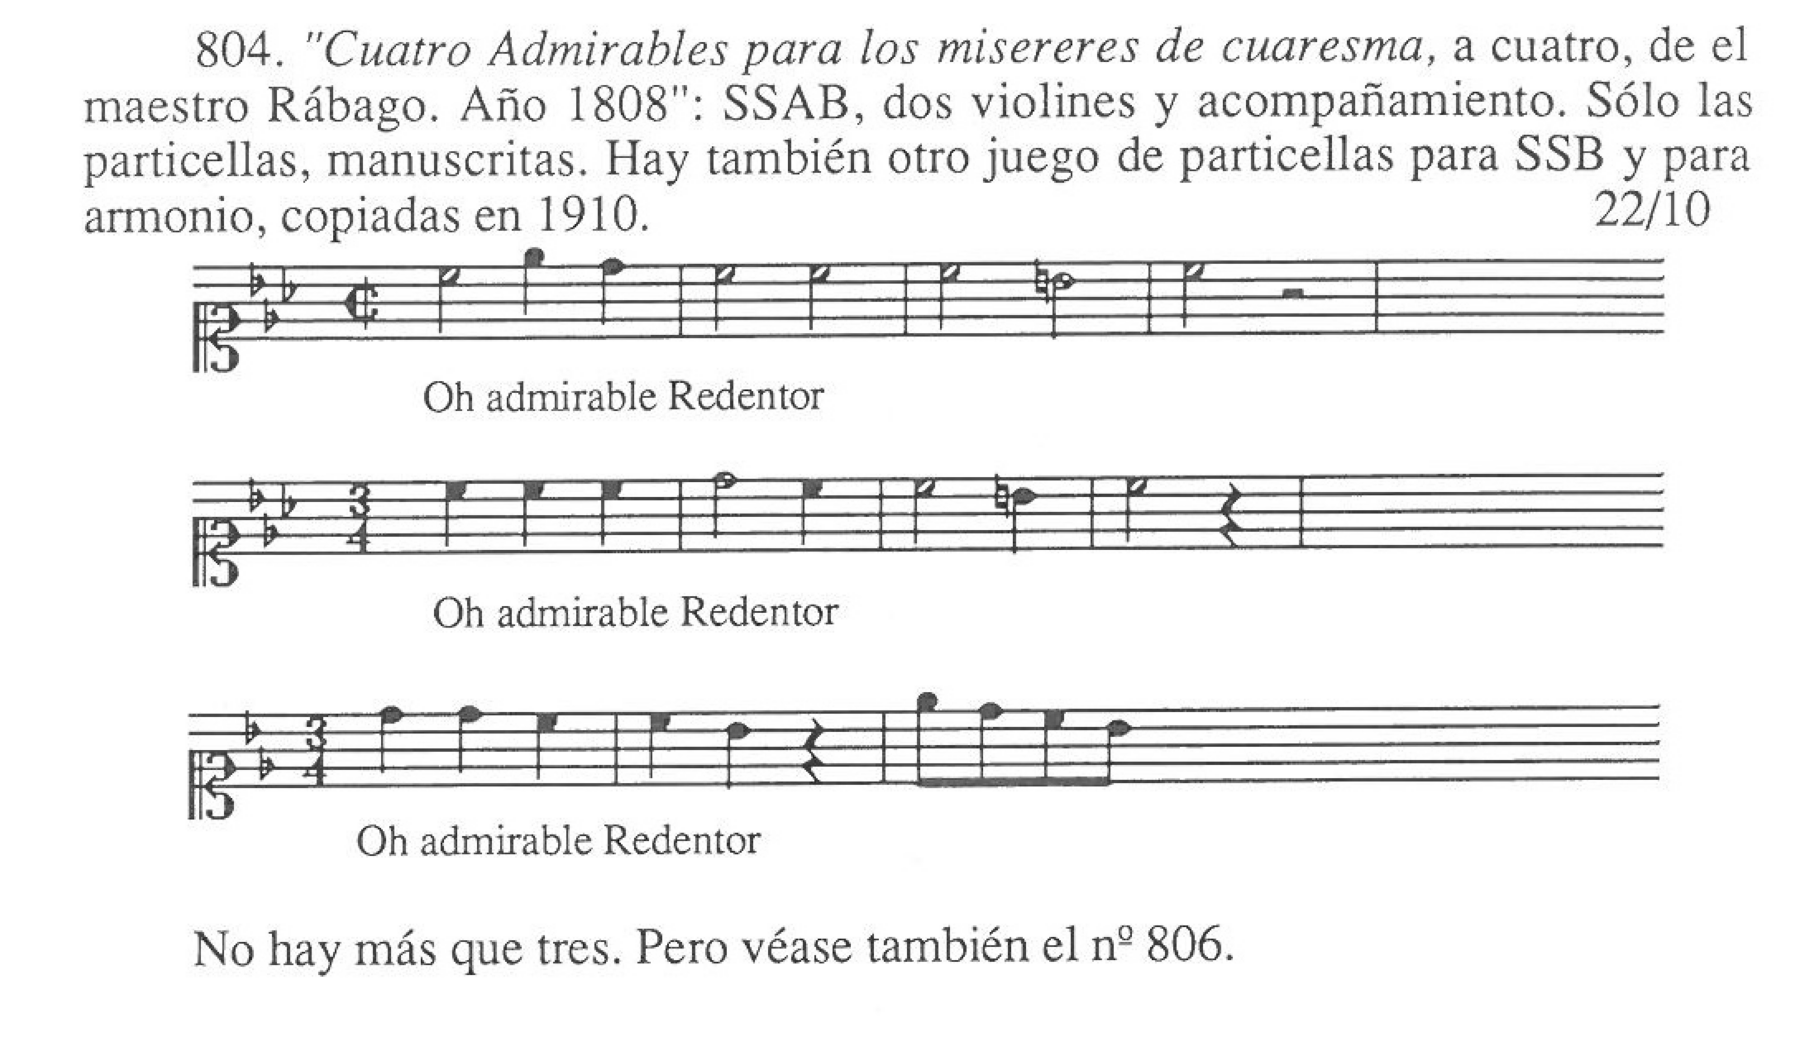

In [ ]:
Obra = []
pag = 179
n = len(Obras_final['Rábago, Manuel de'][804]['Coordenadas'])
for j in range(0,n):
  x,y,w,h = Obras_final['Rábago, Manuel de'][804]['Coordenadas'][j]
  fot = cv2.imread('Fotos/pag'+str(pag+j)+'.jpg')
  fot = cv2.cvtColor(fot,cv2.COLOR_BGR2RGB)
  Obra.append(fot[y:y+h+5,x:x+w])
Obra = np.concatenate(Obra,axis=0)
mostrarImagen(Obra)

In [ ]:
data = image2data(Obra)

        Preprocesando los pentagramas:
       --------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

        Preprocesando el texto:
       --------------------------------


In [ ]:
print(data)

{'pent_0': {'bboxes': [(0, 85, 40, 86), (36, 22, 59, 86), (47, 85, 70, 86), (60, 53, 81, 86), (108, 85, 142, 86), (174, 59, 203, 86), (237, 0, 264, 86), (296, 24, 322, 86), (352, 69, 366, 86), (375, 43, 405, 86), (445, 38, 475, 86), (518, 53, 531, 86), (541, 39, 569, 86), (611, 0, 633, 86), (625, 49, 653, 86), (695, 45, 710, 86), (719, 26, 749, 86), (795, 85, 823, 86), (861, 33, 876, 86)], 'labels': ['claved', 'bem', 'bem', 'bem', '4x4', 'nota2_3', 'nota1_10', 'nota1_9', 'line', 'nota2_9', 'nota2_9', 'line', 'nota2_9', 'bec', 'nota2_9', 'line', 'nota2_9', 'sil2', 'line']}, 'pent_1': {'bboxes': [(0, 79, 41, 80), (35, 0, 57, 80), (46, 79, 68, 80), (61, 20, 81, 80), (108, 18, 136, 80), (180, 24, 207, 80), (237, 31, 263, 80), (293, 25, 322, 80), (352, 37, 365, 80), (377, 0, 406, 80), (442, 20, 468, 80), (499, 31, 512, 80), (522, 0, 551, 80), (582, 0, 604, 80), (596, 48, 625, 80), (653, 28, 667, 80), (678, 0, 708, 80), (749, 15, 774, 80), (806, 7, 822, 80)], 'labels': ['claved', 'bem', 'bem

## Salto a xml
- Transforma esa lista de elementos a el formato musicxml

In [ ]:
claves = {'claves':{-4:'F3', -3:'G3', -2:'A3', -1:'B3', 0:'C4', 1:'D4', 2:'E4', 3:'F4', 4:'G4', 5:'A4', 6:'B4', 7:'C5', 8:'D5', 9:'E5', 10:'F5', 11:'G5', 12:'A5', 13:'B5', 14:'C6'},
          'clavef4':{-4:'A1', -3:'B1', -2:'C2', -1:'D2', 0:'E2', 1:'F2', 2:'G2', 3:'A2', 4:'B2', 5:'C3', 6:'D3', 7:'E3', 8:'F3', 9:'G3', 10:'A3', 11:'B3', 12:'C4', 13:'D4', 14:'E4'},
          'claved1':{-4:'D3', -3:'E3', -2:'F3', -1:'G3', 0:'A3', 1:'B3', 2:'C4', 3:'D4', 4:'E4', 5:'F4', 6:'G4', 7:'A4', 8:'B4', 9:'C5', 10:'D5', 11:'E5', 12:'F5', 13:'G5', 14:'A5'},
          'claved3':{-4:'G2', -3:'A2', -2:'B2', -1:'C3', 0:'D3', 1:'E3', 2:'F3', 3:'G3', 4:'A3', 5:'B3', 6:'C4', 7:'D4', 8:'E4', 9:'F4', 10:'G4', 11:'A4', 12:'B4', 13:'C5', 14:'D5'},
          'claved4':{-4:'E2', -3:'F2', -2:'G2', -1:'A2', 0:'B2', 1:'C3', 2:'D3', 3:'E3', 4:'F3', 5:'G3', 6:'A3', 7:'B3', 8:'C4', 9:'D4', 10:'E4', 11:'F4', 12:'G4', 13:'A4', 14:'B4'}}

## Funciones

In [39]:
def crear(dimension):
  score_partwise = ET.Element('score-partwise')
  score_partwise.set('version','3.1')
  defaults = ET.SubElement(score_partwise,'defaults')
  scaling = ET.SubElement(defaults,'scaling')
  millimeters = ET.SubElement(scaling,'millimeters')
  millimeters.text = '4.8'
  tenths = ET.SubElement(scaling,'tenths')
  tenths.text = '40'
  page_layout = ET.SubElement(defaults,'page-layout')
  page_height = ET.SubElement(page_layout,'page-height')
  page_height.text = str(dimension[1])
  page_width = ET.SubElement(page_layout,'page-width')
  page_width.text = str(dimension[0])
  page_margins = ET.SubElement(page_layout,'page-margins')
  left_margin = ET.SubElement(page_margins,'left-margin')
  left_margin.text = '150'
  right_margin = ET.SubElement(page_margins,'right-margin')
  right_margin.text = '150'
  top_margin = ET.SubElement(page_margins,'top-margin')
  top_margin.text = '10'
  bottom_margin = ET.SubElement(page_margins,'bottom-margin')
  bottom_margin.text = '10'
  word_font = ET.SubElement(defaults,'word-font')
  word_font.set('font-family','Edwin')
  word_font.set('font-size','10')
  lyric_font = ET.SubElement(defaults,'lyric-font')
  lyric_font.set('font-family','Edwin')
  lyric_font.set('font-size','10')
  part_list = ET.SubElement(score_partwise,'part-list')
  score_part = ET.SubElement(part_list,'score-part')
  score_part.set('id','P1')
  part_name = ET.SubElement(score_part,'part-name')
  part_name.text = 'Piano'
  part_abbreviation = ET.SubElement(score_part,'part-abbreviation')
  part_abbreviation.text = 'Pno.'
  score_instrument = ET.SubElement(score_part,'score-instrument')
  score_instrument.set('id','P1-I1')
  instrument_name = ET.SubElement(score_instrument,'instrument-name')
  instrument_name.text = 'Piano'
  midi_device = ET.SubElement(score_part,'midi-device')
  midi_device.set('id','P1-I1')
  midi_device.set('port','1')
  midi_instrument = ET.SubElement(score_part,'midi-instrument')
  midi_instrument.set('id','P1-I1')
  midi_chanel = ET.SubElement(midi_instrument,'midi-chanel')
  midi_chanel.text = '1'
  midi_program = ET.SubElement(midi_instrument,'midi-program')
  midi_program.text = '1'
  volume = ET.SubElement(midi_instrument,'volume')
  volume.text = '78.7402'
  pan = ET.SubElement(midi_instrument,'pan')
  pan.text = '78.7402'
  part = ET.SubElement(score_partwise,'part')
  part.set('id','P1')
  return score_partwise

In [48]:
def add_measuere(mydata,inicio=False):
  idx = [a.tag for a in mydata.getchildren()].index('part')
  part = mydata.getchildren()[idx]
  if inicio != False:
    measure = ET.SubElement(part,'measure')
    print = ET.SubElement(measure,'print')
    print.set('new-system','yes')
    system_layout = ET.SubElement(print,'system-layout')
    system_margins = ET.SubElement(system_layout,'system-margins')
    left_margin = ET.SubElement(system_margins,'left-margin')
    left_margin.text = '50.00'
    right_margin = ET.SubElement(system_margins,'right-margin')
    right_margin.text = '50.00'
    system_distance = ET.SubElement(system_layout,'system-distance')
    system_distance.text = '85'
    attributes = ET.SubElement(measure,'attributes')
    divisions = ET.SubElement(attributes,'divisions')
    divisions.text = '32'
    key = ET.SubElement(attributes,'key')
    fifths = ET.SubElement(key,'fifths')
    fifths.text = str(inicio['fifths'])
    time = ET.SubElement(attributes,'time')
    beats = ET.SubElement(time,'beats')
    beats.text = str(inicio['compas'][0])
    beat_type = ET.SubElement(time,'beat-type')
    beat_type.text = str(inicio['compas'][2])
    clef = ET.SubElement(attributes,'clef')
    sing = ET.SubElement(clef,'sing')
    sing.text = str(inicio['clef'][0])
    line = ET.SubElement(clef,'line')
    line.text = str(inicio['clef'][1])
  else:
    measure = ET.SubElement(part,'measure')
  return mydata

## Ejemplo

In [52]:
%%capture
mydata = crear((1300,600))
inicio = {'fifths':-3,'compas':'6x8','clef':'G2'}
mydata = add_measuere(mydata,inicio)
mydata = add_measuere(mydata)
mydata = add_measuere(mydata)
mydata = add_measuere(mydata)
mydata = prettify(mydata)
with open("items2.xml", "w") as myfile:
  myfile.write(mydata)